## Drowsy Driver Detection Using CNN

- A Deep Learning Approach to Enhancing Road Safety

- Using convolutional neural networks to identify drowsy drivers and prevent accidents before they happen.

## Github Link For this file :
https://github.com/kirkboyd1/DeepLearningFinal/blob/main/Drowsy_Driver_Detection.ipynb

### Driver Drowsiness Dataset (DDD)
- More than 41,790 images for Driver Drowsiness Detection

https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd

### About The Dataset
The Driver Drowsiness Dataset (DDD) is an extracted and cropped faces of drivers from the videos of the Real-Life Drowsiness Dataset. The frames were extracted from videos as images using VLC software. After that, the Viola-Jones algorithm has been used to extract the region of interest from captured images. The obtained dataset (DDD) has been used for training and testing CNN architecture for driver drowsiness detection in the “Detection and Prediction of Driver Drowsiness for the Prevention of Road Accidents Using Deep Neural Networks Techniques” paper.
(Please cite the following research paper)
https://doi.org/10.1007/978-981-33-6893-4_6
The dataset has the following properties :
• RGB images
• 2 classes (Drowsy & Non Drowsy)
• Size of image : 227 x 227
• More than 41,790 images in total
• File size : 2.32 Go

## Downloading Drowsiness Detection Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Colab_Notebooks/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ismailnasri20/driver-drowsiness-dataset-ddd

100% 2.57G/2.58G [00:29<00:00, 77.9MB/s]
100% 2.58G/2.58G [00:29<00:00, 94.0MB/s]


In [ ]:
!unzip /content/driver-drowsiness-dataset-ddd.zip

Streaming output truncated to the last 5000 lines.
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0082.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0083.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0084.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0085.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0086.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0087.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0088.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0089.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0090.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0091.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0092.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0093.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0094.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0095.png

## Importing the Necessary Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import cv2
from PIL import Image
from tqdm import tqdm

from skimage.io import imread
from skimage.transform import rescale
from skimage.feature import hog
from skimage import exposure
from skimage import color

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras.models import Sequential, Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam, Adamax
from keras.layers import Input, UpSampling2D, Conv2D, concatenate, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.regularizers import l1, l2

from keras.src.applications import InceptionResNetV2
from keras.src.applications.inception_resnet_v2 import preprocess_input

import os
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Creating a Combined Image Dataset with Labels

In [ ]:
data_dir = "/content/Driver Drowsiness Dataset (DDD)"

drowsy_df = pd.DataFrame(columns=['filepaths', 'labels'])
non_drowsy_df = pd.DataFrame(columns=['filepaths', 'labels'])


drowsy_label = 'drowsy'
non_drowsy_label = 'non_drowsy'

drowsy_files = os.listdir(os.path.join(data_dir, "Drowsy"))
non_drowsy_files = os.listdir(os.path.join(data_dir, "Non Drowsy"))

drowsy_df['filepaths'] = [os.path.join(data_dir, "Drowsy", filename) for filename in drowsy_files]
drowsy_df['labels'] = drowsy_label

non_drowsy_df['filepaths'] = [os.path.join(data_dir, "Non Drowsy", filename) for filename in non_drowsy_files]
non_drowsy_df['labels'] = non_drowsy_label

In [ ]:
combined_df = pd.concat([drowsy_df, non_drowsy_df], ignore_index=True)

combined_df = combined_df.sample(frac=1, random_state=42)
label_counts = combined_df['labels'].value_counts()

label_counts

drowsy        22348
non_drowsy    19445
Name: labels, dtype: int64

In [ ]:
combined_df.head(5)

filepaths      labels
29183  /content/Driver Drowsiness Dataset (DDD)/Non D...  non_drowsy
11257  /content/Driver Drowsiness Dataset (DDD)/Drows...      drowsy
7090   /content/Driver Drowsiness Dataset (DDD)/Drows...      drowsy
5987   /content/Driver Drowsiness Dataset (DDD)/Drows...      drowsy
2111   /content/Driver Drowsiness Dataset (DDD)/Drows...      drowsy

## EDA - Exploring Data Distribution and Visualizing Images

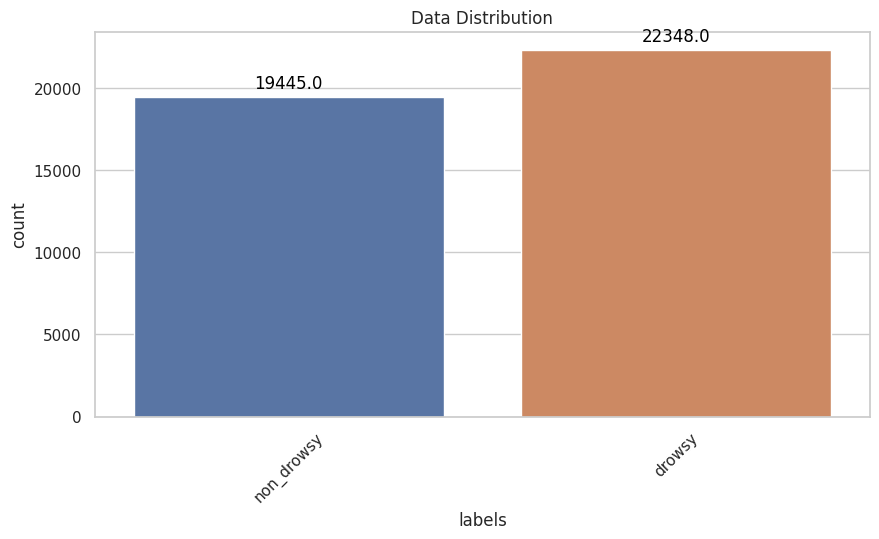

In [ ]:
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")
ax = sns.countplot(data=combined_df, x='labels')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), textcoords='offset points')

plt.title('Data Distribution')
plt.xticks(rotation=45)
plt.show()


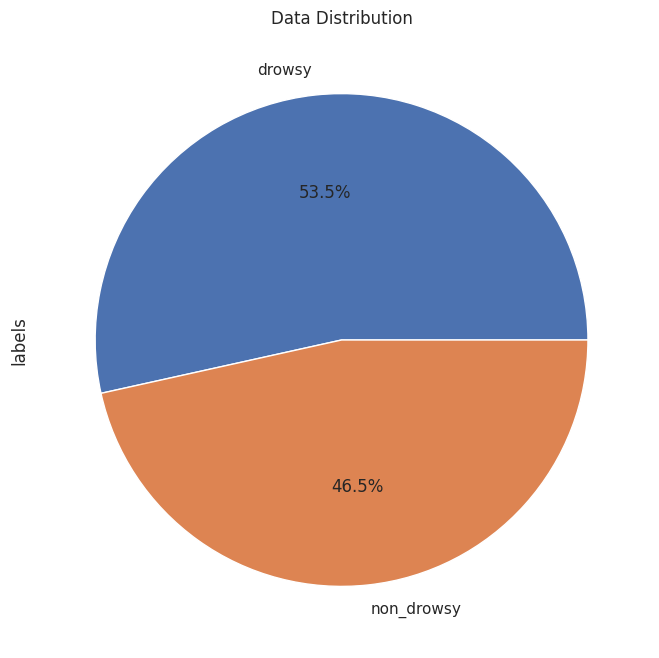

In [ ]:
plt.figure(figsize=(10, 8))
combined_df['labels'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Data Distribution')
plt.show()

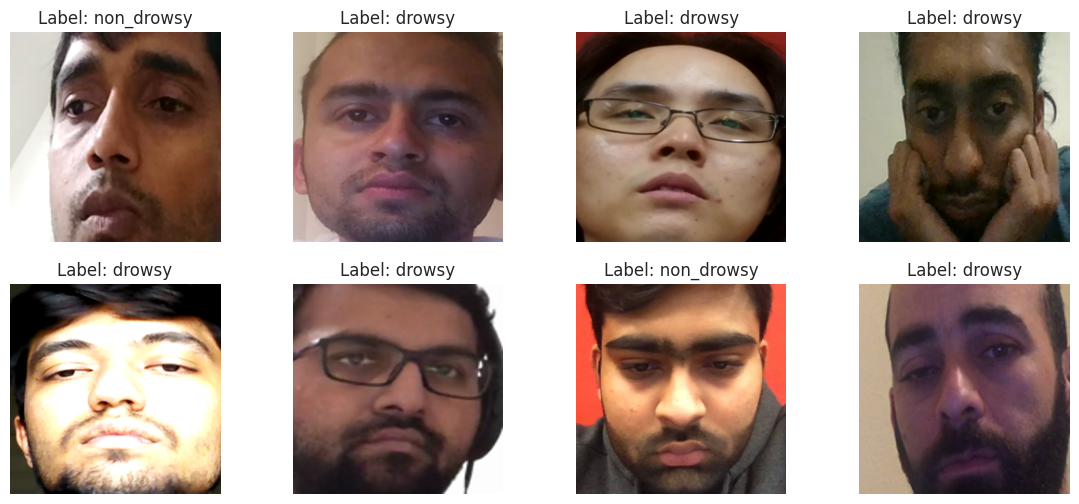

In [ ]:
def display_images(df, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(14, 6))
    for r in range(rows):
        for c in range(cols):
            index = r * cols + c
            if index < len(df):
                image_path = df.iloc[index]['filepaths']
                label = df.iloc[index]['labels']
                img = Image.open(image_path)
                axes[r, c].imshow(img)
                axes[r, c].set_title(f'Label: {label}')
                axes[r, c].axis('off')
            else:
                axes[r, c].axis('off')

    plt.show()

rows = 2
cols = 4

display_images(combined_df, rows, cols)

## Data Preprocessing - Data Splitting and Class Distribution in Image Dataset

In [ ]:
train_df, dummy_df = train_test_split(combined_df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= combined_df['labels'])

valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= dummy_df['labels'])

In [ ]:
train_df['labels'].value_counts()

drowsy        17878
non_drowsy    15556
Name: labels, dtype: int64

In [ ]:
test_df['labels'].value_counts()

drowsy        2235
non_drowsy    1945
Name: labels, dtype: int64

In [ ]:
valid_df['labels'].value_counts()

drowsy        2235
non_drowsy    1944
Name: labels, dtype: int64

#Data Preprocessing and Generation

In [ ]:
def scalar(img):
        return img

train_generator = ImageDataGenerator(preprocessing_function = scalar,
                                     horizontal_flip = True)

test_generator = ImageDataGenerator(preprocessing_function = scalar)

In [ ]:
train_set = train_generator.flow_from_dataframe( train_df,
                                        x_col= 'filepaths',
                                        y_col= 'labels',
                                        target_size= (224, 224),
                                        class_mode= 'categorical',
                                        color_mode= 'rgb',
                                        shuffle= True,
                                        batch_size= 128)

train_set.class_indices

Found 33434 validated image filenames belonging to 2 classes.


{'drowsy': 0, 'non_drowsy': 1}

In [ ]:
valid_set = test_generator.flow_from_dataframe( valid_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= (224, 224),
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= 128)


Found 4179 validated image filenames belonging to 2 classes.


In [ ]:
test_set = test_generator.flow_from_dataframe( test_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= (224, 224),
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= False,
                                      batch_size= 128)

Found 4180 validated image filenames belonging to 2 classes.


## Deep Learning Models

### Transfer Learning(TL)

### InceptionResNetV2-based Neural Network Architecture

In [ ]:
base_model = InceptionResNetV2(include_top= False, weights= "imagenet", input_shape= (224,224,3), pooling= 'max')

x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)

x = Dense(256, kernel_regularizer=l2(l=0.016), activity_regularizer=l1(0.006), bias_regularizer=l1(0.006), activation='relu')(x)
x = Dropout(rate=0.3)(x)

output = Dense(2, activation='softmax')(x)

model = Model(inputs = base_model.input, outputs = output)

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

### Training the Model

In [ ]:
history = model.fit(x= train_set,
                    epochs= 10,
                    verbose= 1,
                    validation_data= valid_set
)

Epoch 1/10
262/262 [==============================] - 672s 2s/step - loss: 3.3135 - accuracy: 0.9884 - val_loss: 1.5420 - val_accuracy: 0.9974
Epoch 2/10
262/262 [==============================] - 562s 2s/step - loss: 0.9609 - accuracy: 0.9974 - val_loss: 0.5458 - val_accuracy: 0.9993
Epoch 3/10
262/262 [==============================] - 562s 2s/step - loss: 0.3705 - accuracy: 0.9984 - val_loss: 0.2200 - val_accuracy: 1.0000
Epoch 4/10
262/262 [==============================] - 561s 2s/step - loss: 0.1708 - accuracy: 0.9988 - val_loss: 0.1103 - val_accuracy: 0.9995
Epoch 5/10
262/262 [==============================] - 561s 2s/step - loss: 0.1027 - accuracy: 0.9989 - val_loss: 0.0696 - val_accuracy: 1.0000
Epoch 6/10
262/262 [==============================] - 562s 2s/step - loss: 0.0745 - accuracy: 0.9996 - val_loss: 0.0566 - val_accuracy: 1.0000
Epoch 7/10
262/262 [==============================] - 561s 2s/step - loss: 0.0643 - accuracy: 0.9992 - val_loss: 0.0521 - val_accuracy: 0.9995

### Training and Validation Performance Visualization

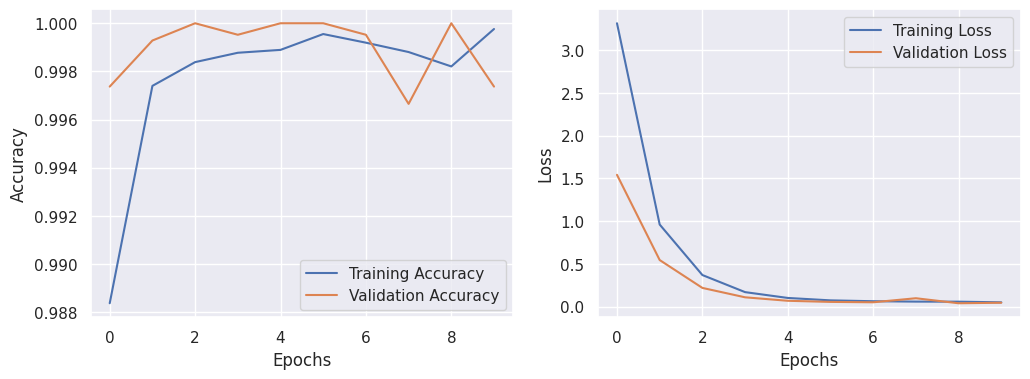

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Model Evaluation and Image Prediction

In [ ]:
model.save("Drowsy_InceptionResntV2.h5")

In [ ]:
model = load_model("/content/Drowsy_InceptionResntV2.h5")

In [ ]:
train_results = model.evaluate(train_set, verbose= 1)
valid_results = model.evaluate(valid_set, verbose= 1)
test_results = model.evaluate(test_set, verbose= 1)

print("\nTrain Loss: ", train_results[0])
print("Train Accuracy: ", train_results[1])
print('-' * 40)

print("Validation Loss: ", valid_results[0])
print("Validation Accuracy: ", valid_results[1])
print('-' * 40)

print("Test Loss: ", test_results[0])
print("Test Accuracy: ", test_results[1])

33/33 [==============================] - 31s 927ms/step - loss: 0.0498 - accuracy: 0.9974

Train Loss:  0.05194609612226486
Train Accuracy:  0.9980259537696838
----------------------------------------
Validation Loss:  0.046787165105342865
Validation Accuracy:  0.997367799282074
----------------------------------------
Test Loss:  0.04979972168803215
Test Accuracy:  0.9973683953285217


In [ ]:
class_names = list(test_set.class_indices.keys())

predictions = model.predict_generator(test_set, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_set.classes

class_report = classification_report(true_labels, predicted_labels, target_names = class_names)
print("Classification Report:\n", class_report)

33/33 [==============================] - 24s 637ms/step
Classification Report:
               precision    recall  f1-score   support

      drowsy       1.00      1.00      1.00      2235
  non_drowsy       1.00      0.99      1.00      1945

    accuracy                           1.00      4180
   macro avg       1.00      1.00      1.00      4180
weighted avg       1.00      1.00      1.00      4180



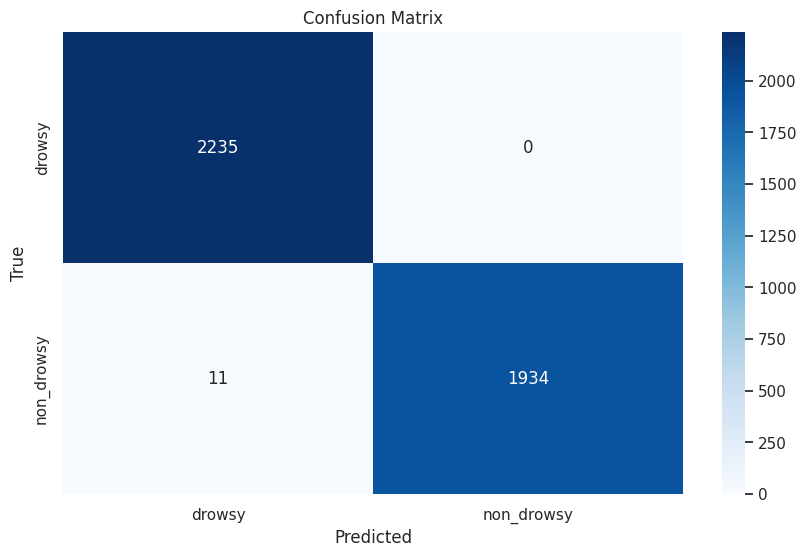

In [ ]:
confusion_mat = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_mat, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_names, yticklabels = class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

1/1 [==============================] - 0s 60ms/step


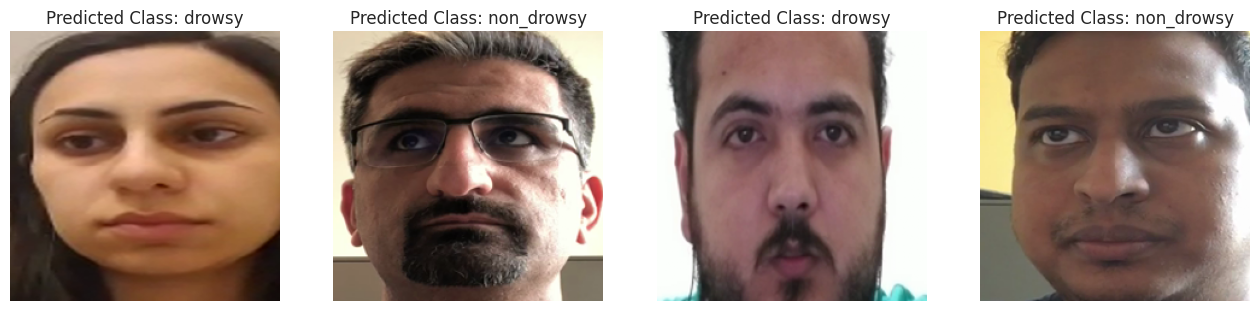

In [ ]:
def predict_and_display_images(image_paths, model):
    class_labels = ['drowsy', 'non_drowsy']

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for i, image_path in enumerate(image_paths):
        img = image.load_img(image_path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        predictions = model.predict(img)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_class = class_labels[predicted_class_index]

        ax = axes[i]
        ax.imshow(img[0] / 255.0)
        ax.set_title(f"Predicted Class: {predicted_class}")
        ax.axis('off')

    plt.show()

image_paths = [
    '/content/Driver Drowsiness Dataset (DDD)/Drowsy/G0011.png',
    '/content/Driver Drowsiness Dataset (DDD)/Non Drowsy/a0012.png',
    '/content/Driver Drowsiness Dataset (DDD)/Drowsy/F0093.png',
    '/content/Driver Drowsiness Dataset (DDD)/Non Drowsy/b0500.png'
]


predict_and_display_images(image_paths, model)

### Activation Map Visualization and Attention Map Generation

In [ ]:
def visualize_activation_maps(model, img_path, layer_name):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    activations = intermediate_model.predict(img_array)

    num_filters = activations.shape[-1]
    rows = int(np.ceil(num_filters / 8))

    fig, axs = plt.subplots(nrows=rows, ncols=8, figsize=(16, rows*2))

    for i in range(rows):
        for j in range(8):
            if i*8 + j < num_filters:
                axs[i, j].imshow(activations[0, :, :, i*8 + j])
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

layer_name = 'conv2d_1'
img_path = '/content/Driver Drowsiness Dataset (DDD)/Drowsy/G0011.png'

visualize_activation_maps(model, img_path, layer_name)

1/1 [==============================] - 0s 106ms/step


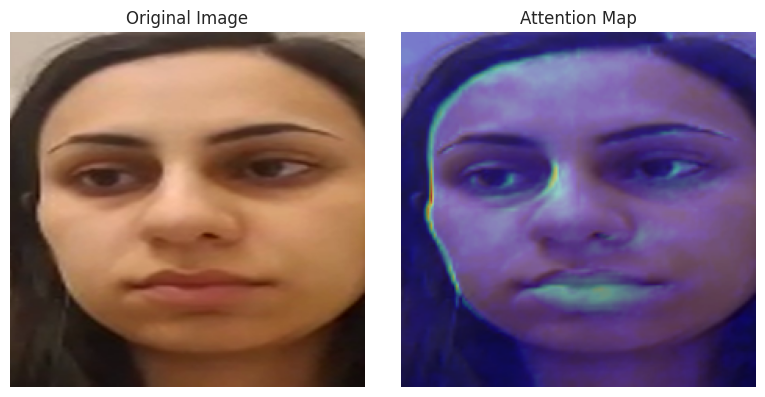

In [ ]:
def get_gradcam(model, img_array, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

def visualize_attention(image_path, heatmap):
    img = cv2.imread(image_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Attention Map')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

image_path = '/content/Driver Drowsiness Dataset (DDD)/Drowsy/G0011.png'
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

layer_name = 'conv2d'
heatmap = get_gradcam(model, img_array, layer_name)

visualize_attention(image_path, heatmap)

## Convolutional Neural Network(CNN)

### Convolutional Neural Network with Parallel Convolution Architecture

In [ ]:
def parallel_convolution_blocks(x, filters):
    conv1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    conv1x1_3x3 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv1x1_3x3)

    conv1x1_5x5 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv1x1_5x5)

    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    conv1x1_maxpool = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(maxpool)

    feature_fusion = concatenate([conv1x1, conv3x3, conv5x5, conv1x1_maxpool], axis=-1)
    return feature_fusion

input = Input(shape=(224, 224, 3))
x = input

x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

x = parallel_convolution_blocks(x, [64, 128, 128, 32, 32, 32])
x = parallel_convolution_blocks(x, [128, 192, 96, 64, 64, 64])
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

x = parallel_convolution_blocks(x, [32, 64, 64, 16, 16, 32])
x = parallel_convolution_blocks(x, [64, 192, 128, 64, 64, 32])
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

x = parallel_convolution_blocks(x, [64, 128, 128, 32, 32, 32])
x = parallel_convolution_blocks(x, [128, 192, 96, 128, 128, 128])
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

output = Dense(2, activation='softmax')(x)

model = Model(input, output)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_240 (Conv2D)         (None, 112, 112, 64)         9472      ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_14 (MaxPooli  (None, 56, 56, 64)           0         ['conv2d_240[0][0]']          
 ng2D)                                                                                            
                                                                                                  
 conv2d_242 (Conv2D)         (None, 56, 56, 128)          8320      ['max_pooling2d_14[0][0

### Training the Model

In [ ]:
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath = 'Drowsy_CNN_with_Parallel_Convolution.h5',
    monitor = 'val_accuracy',
    save_best_only = True,
    mode = 'max',
    verbose = 1
)

In [ ]:
history = model.fit(
    train_set,
    validation_data = valid_set,
    epochs = 10,
    callbacks = [checkpoint_callback],
    verbose = 1
)

Epoch 1/10
262/262 [==============================] - ETA: 0s - loss: 1.1762 - accuracy: 0.5822
Epoch 1: val_accuracy improved from -inf to 0.72481, saving model to Drowsy_CNN_with_Parallel_Convolution.h5
262/262 [==============================] - 255s 870ms/step - loss: 1.1762 - accuracy: 0.5822 - val_loss: 0.5394 - val_accuracy: 0.7248
Epoch 2/10
262/262 [==============================] - ETA: 0s - loss: 0.5351 - accuracy: 0.6961
Epoch 2: val_accuracy improved from 0.72481 to 0.82795, saving model to Drowsy_CNN_with_Parallel_Convolution.h5
262/262 [==============================] - 191s 726ms/step - loss: 0.5351 - accuracy: 0.6961 - val_loss: 0.4231 - val_accuracy: 0.8279
Epoch 3/10
262/262 [==============================] - ETA: 0s - loss: 0.2230 - accuracy: 0.9040
Epoch 3: val_accuracy improved from 0.82795 to 0.96722, saving model to Drowsy_CNN_with_Parallel_Convolution.h5
262/262 [==============================] - 188s 716ms/step - loss: 0.2230 - accuracy: 0.9040 - val_loss: 0.08

### Training and Validation Performance Visualization

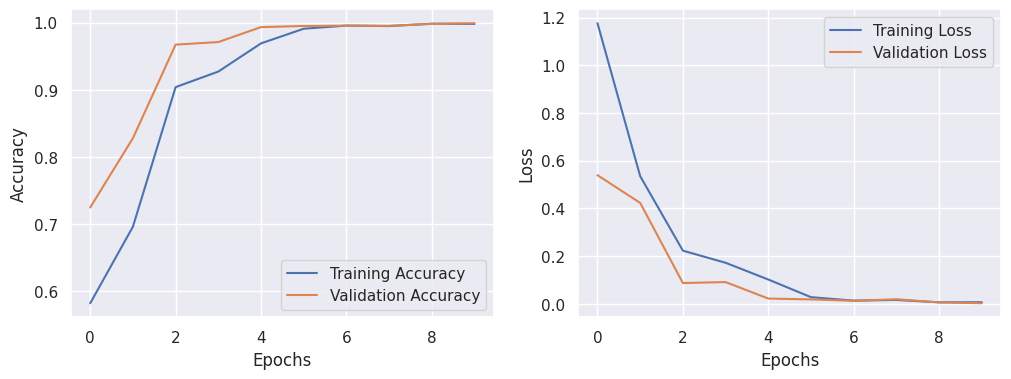

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Model Evaluation and Image Prediction

In [ ]:
model = load_model("/content/Drowsy_CNN_with_Parallel_Convolution.h5")

In [ ]:
train_results = model.evaluate(train_set, verbose= 1)
valid_results = model.evaluate(valid_set, verbose= 1)
test_results = model.evaluate(test_set, verbose= 1)

print("\nTrain Loss: ", train_results[0])
print("Train Accuracy: ", train_results[1])
print('-' * 40)

print("Validation Loss: ", valid_results[0])
print("Validation Accuracy: ", valid_results[1])
print('-' * 40)

print("Test Loss: ", test_results[0])
print("Test Accuracy: ", test_results[1])

33/33 [==============================] - 23s 695ms/step - loss: 0.0025 - accuracy: 0.9990

Train Loss:  0.0023482446558773518
Train Accuracy:  0.9993718862533569
----------------------------------------
Validation Loss:  0.002516759093850851
Validation Accuracy:  0.999042809009552
----------------------------------------
Test Loss:  0.002532776677981019
Test Accuracy:  0.9990430474281311


In [ ]:
class_names = list(test_set.class_indices.keys())

predictions = model.predict_generator(test_set, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_set.classes

class_report = classification_report(true_labels, predicted_labels, target_names = class_names)
print("Classification Report:\n", class_report)

33/33 [==============================] - 18s 543ms/step
Classification Report:
               precision    recall  f1-score   support

      drowsy       1.00      1.00      1.00      2235
  non_drowsy       1.00      1.00      1.00      1945

    accuracy                           1.00      4180
   macro avg       1.00      1.00      1.00      4180
weighted avg       1.00      1.00      1.00      4180



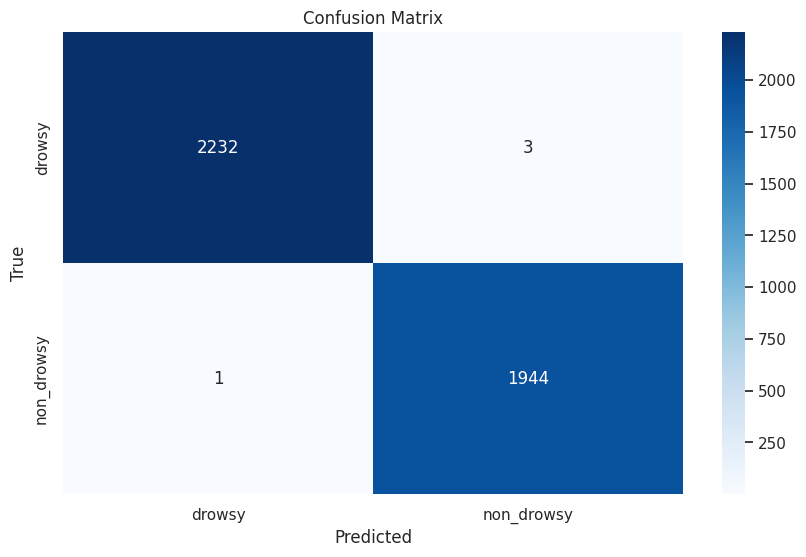

In [ ]:
confusion_mat = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_mat, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_names, yticklabels = class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

1/1 [==============================] - 0s 20ms/step


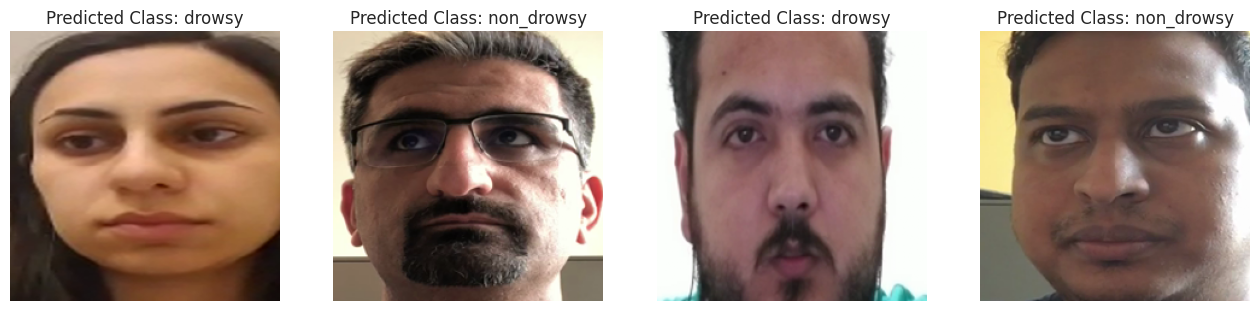

In [ ]:
def predict_and_display_images(image_paths, model):
    class_labels = ['drowsy', 'non_drowsy']

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for i, image_path in enumerate(image_paths):
        img = image.load_img(image_path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        predictions = model.predict(img)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_class = class_labels[predicted_class_index]

        ax = axes[i]
        ax.imshow(img[0] / 255.0)
        ax.set_title(f"Predicted Class: {predicted_class}")
        ax.axis('off')

    plt.show()

image_paths = [
    '/content/Driver Drowsiness Dataset (DDD)/Drowsy/G0011.png',
    '/content/Driver Drowsiness Dataset (DDD)/Non Drowsy/a0012.png',
    '/content/Driver Drowsiness Dataset (DDD)/Drowsy/F0093.png',
    '/content/Driver Drowsiness Dataset (DDD)/Non Drowsy/b0500.png'
]


predict_and_display_images(image_paths, model)

### Activation Map Visualization and Attention Map Generation

1/1 [==============================] - 0s 67ms/step


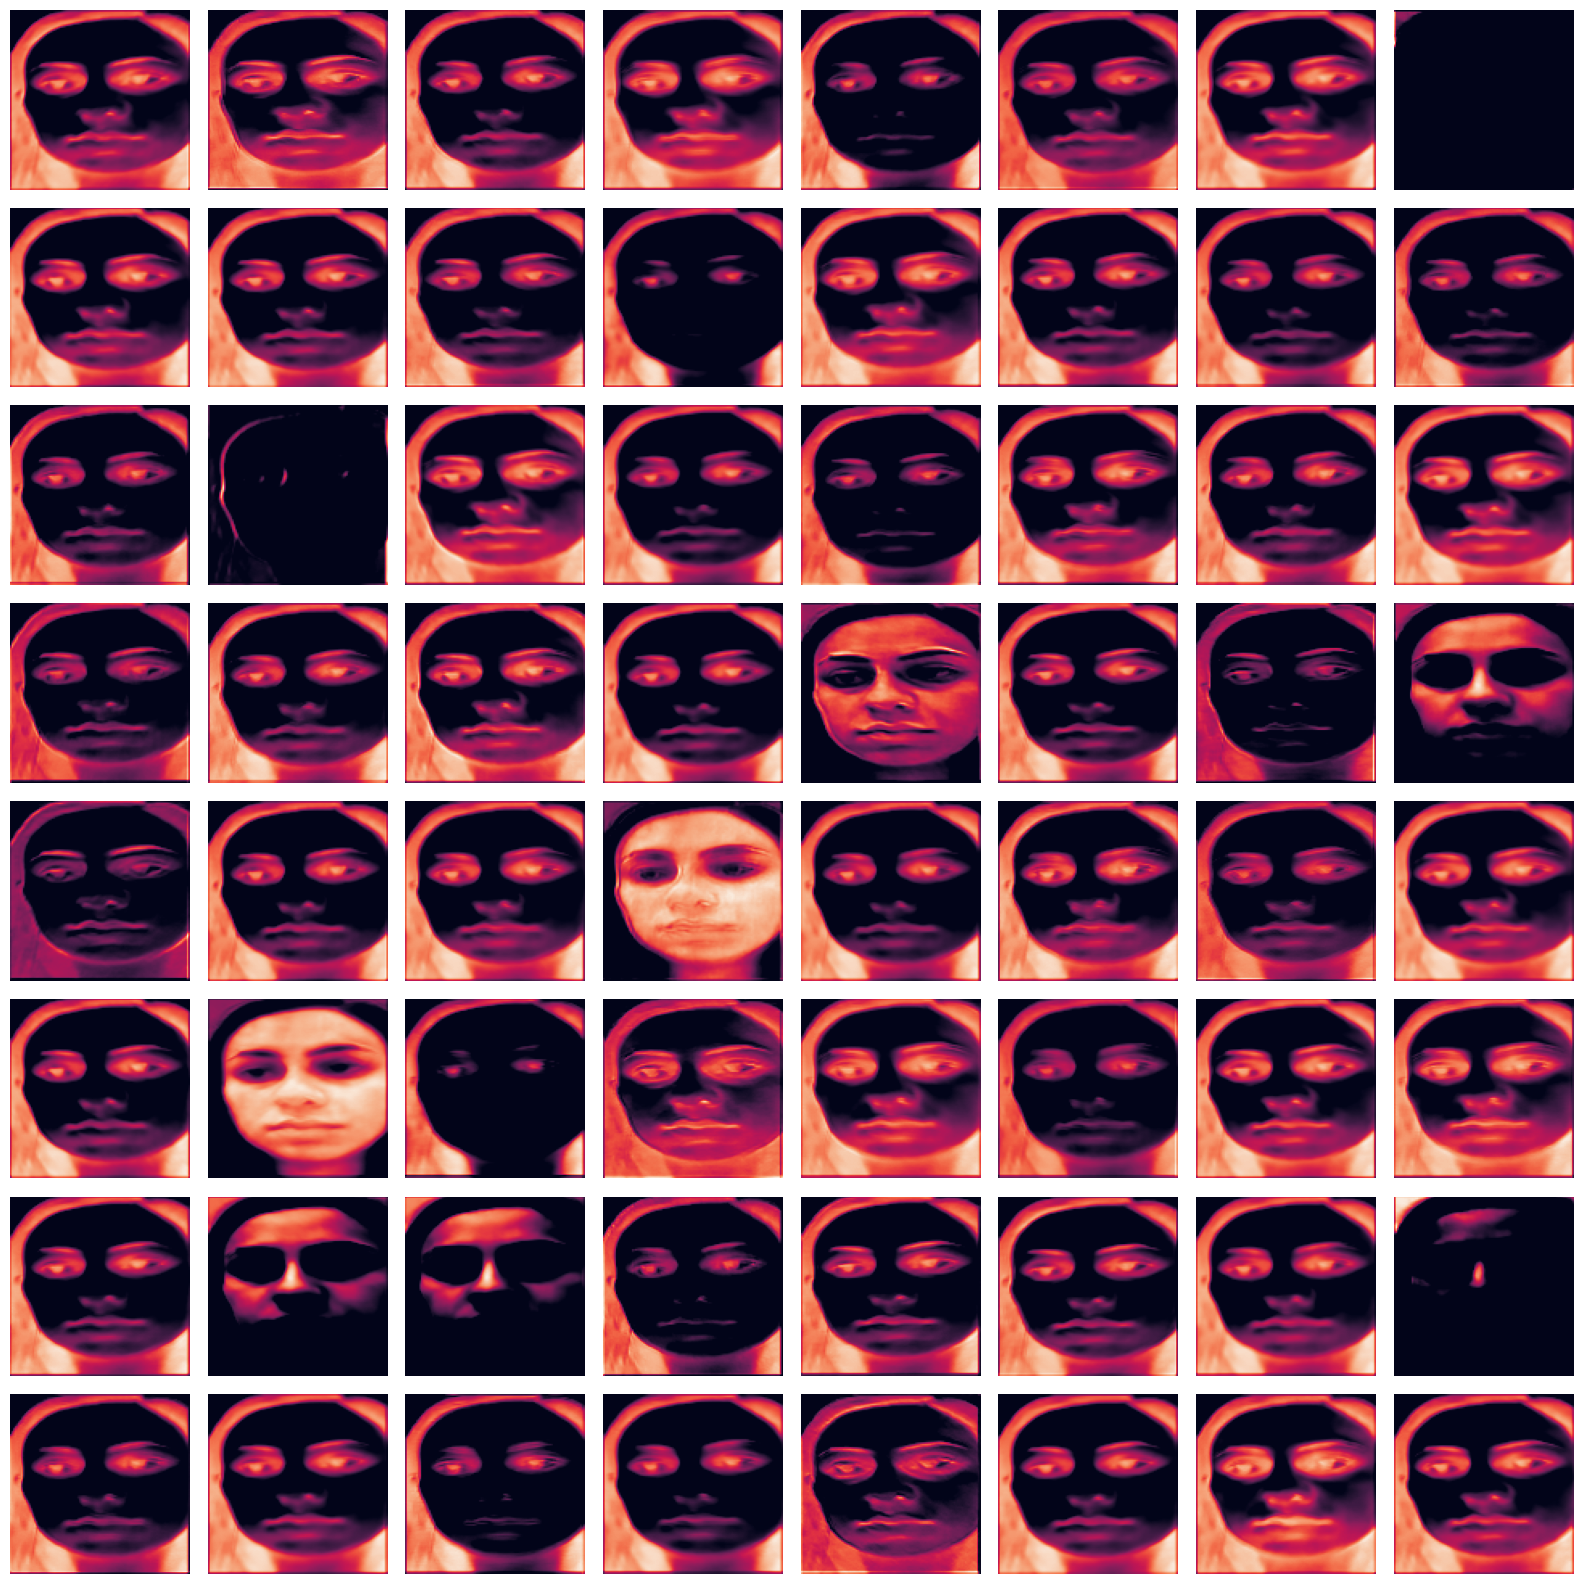

In [ ]:
def visualize_activation_maps(model, img_path, layer_name):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    activations = intermediate_model.predict(img_array)

    num_filters = activations.shape[-1]
    rows = int(np.ceil(num_filters / 8))

    fig, axs = plt.subplots(nrows=rows, ncols=8, figsize=(16, rows*2))

    for i in range(rows):
        for j in range(8):
            if i*8 + j < num_filters:
                axs[i, j].imshow(activations[0, :, :, i*8 + j])
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

layer_name = 'conv2d_240'
img_path = '/content/Driver Drowsiness Dataset (DDD)/Drowsy/G0011.png'

visualize_activation_maps(model, img_path, layer_name)

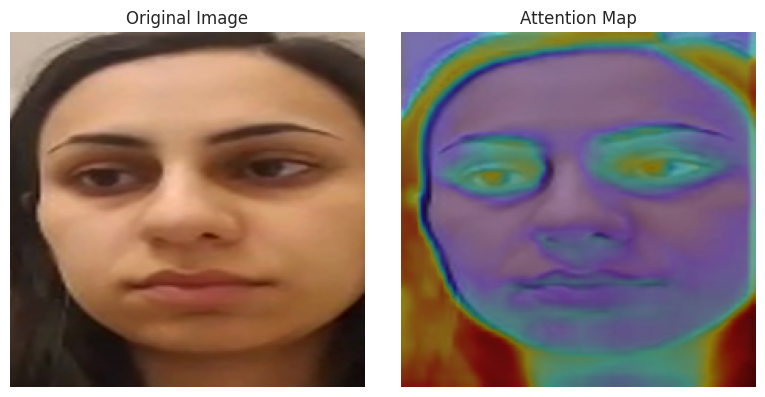

In [ ]:
def get_gradcam(model, img_array, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

def visualize_attention(image_path, heatmap):
    img = cv2.imread(image_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Attention Map')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

image_path = '/content/Driver Drowsiness Dataset (DDD)/Drowsy/G0011.png'
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

layer_name = 'conv2d_242'
heatmap = get_gradcam(model, img_array, layer_name)

visualize_attention(image_path, heatmap)

## Conclusion

- CNN effectively distinguishes between drowsy and alert drivers

- Good accuracy (99%) and generalization on validation/test sets

- Practical implications: integration into safety systems

## Future Work

### Improvements:

- Real-time video stream support

- Eye landmark detection or use of OpenCV

- Try more advanced architectures (EfficientNet, LSTM-CNN)

- Possibility of mobile or embedded deployment (e.g., in dashcams)

References :

1. AlexNet (ImageNet Breakthrough)

Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). ImageNet Classification with Deep Convolutional Neural Networks. In NIPS 2012.
This seminal work demonstrated that deep CNNs trained on ImageNet could drastically outperform traditional methods, reducing top-5 error from ~26% to ~16% 

youtube.com

sciencedirect.com

wjarr.com

arxiv.org

proceedings.neurips.cc

en.wikipedia.org


2. VGG Net (Depth Matters)
Simonyan, K., & Zisserman, A. (2014). Very Deep Convolutional Networks for Large-Scale Image Recognition (VGG16/19).
They showed that increasing depth with small 3×3 filters reliably improves accuracy on ImageNet-scale tasks 

arxiv.org

🔁 Review & Survey Papers on Transfer Learning

3. Ribani & Marengoni (2022)
A Survey of Transfer Learning for Convolutional Neural Networks
Explores the foundations, strategies, and practical considerations in CNN-based transfer learning, emphasizing efficiency when data is limited 

researchgate.net

4. Kim et al. (2022)
Transfer learning for medical image classification: a literature review
Reviews clinical applications that leverage ImageNet pre-trained CNN models for tasks with limited medical datasets 

bmcmedimaging.biomedcentral.com

sciencedirect.com

researchgate.net

arxiv.org